In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import io
from PIL import Image
import torch.nn.functional as F
import math

In [3]:
torch.manual_seed(42)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

device = "cuda"

Using cuda device
GPU: NVIDIA GeForce RTX 3060


# Data loading

In [5]:
training_data_path = Path("data/CMI/train.csv")
training_data_demo_path = Path("data/CMI/train_demographics.csv")

test_data_path = Path("data/CMI/test.csv")
test_data_demo_path = Path("data/CMI/test_demographics.csv")


train_df = pd.read_csv(training_data_path)
train_demo_df = pd.read_csv(training_data_demo_path)
test_df = pd.read_csv(test_data_path)
test_demo_df = pd.read_csv(test_data_demo_path)


# Data visualization

In [6]:
train_df.head(60)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,SEQ_000007_000005,Target,SEQ_000007,5,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.996094,...,-1.0,-1.0,118.0,114.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,SEQ_000007_000006,Target,SEQ_000007,6,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.035156,...,-1.0,-1.0,104.0,118.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,SEQ_000007_000007,Target,SEQ_000007,7,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.730469,...,-1.0,-1.0,105.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,SEQ_000007_000008,Target,SEQ_000007,8,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,4.535156,...,-1.0,-1.0,103.0,122.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,SEQ_000007_000009,Target,SEQ_000007,9,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,3.921875,...,-1.0,-1.0,104.0,123.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Dataset

In [7]:
class CMIIMUDataset(Dataset):
    def __init__(self, df, transform=None, device='cpu'):
        self.device = device
        self.df = df
        self.transform = transform
        self.features = []  # Initialize features list
        self.scaler = StandardScaler()

        excluded_cols = {
            'gesture', 'sequence_type', 'behavior', 'orientation',  # train-only
            'row_id', 'subject', 'phase',  # metadata
            'sequence_id', 'sequence_counter'  # identifiers
        }
        
        thermal_tof_cols = [col for col in df.columns if col.startswith('thm_') or col.startswith('tof_')]
        excluded_cols.update(thermal_tof_cols)

        # Get feature columns (all columns except excluded ones)
        feature_cols = [col for col in df.columns if col not in excluded_cols]

        # Build sequences
        for seq_id, group in df.groupby('sequence_id'):
            data = group[feature_cols].copy()

            # fill missing values forward and backward
            data = pd.DataFrame(data).ffill().bfill().fillna(0).values

            # Standardize features
            data = self.scaler.fit_transform(data)
            self.features.append(data)  # Convert to numpy array

        # Store both gesture labels and sequence types
        self.labels = df.groupby('sequence_id')['gesture'].first().values
        self.sequence_types = df.groupby('sequence_id')['sequence_type'].first().values

        # Pad sequences to the same length
        self.features = nn.utils.rnn.pad_sequence([torch.tensor(f, dtype=torch.float32, device=self.device) for f in self.features], batch_first=True)

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)
        self.labels = torch.tensor(self.labels, dtype=torch.long, device=self.device)

    def print(self):
        print(self.features.shape)
        print(self.labels.shape)
        print(self.features[:3])
        print(self.labels[:3])
        print("\nSequence types sample:", self.sequence_types[:3])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature, label

In [8]:
dataset = CMIIMUDataset(train_df, device=device)
dataset.print()

# Print unique gestures and their encoded values
print("\nUnique gestures and their encoded values:")
for gesture, encoded in zip(np.unique(train_df['gesture']), torch.unique(dataset.labels)):
    print(f"Gesture: {gesture} -> Encoded: {encoded}")

print("\nNumber of unique gestures:", len(np.unique(train_df['gesture'])))

torch.Size([8151, 700, 7])
torch.Size([8151])
tensor([[[ 0.4012,  0.7610, -0.9592,  ..., -1.3253, -0.6677,  0.6997],
         [ 0.6020,  0.7610, -1.0586,  ..., -1.0598, -0.5601,  0.3337],
         [-0.3255,  0.4947, -0.0673,  ...,  0.1174, -0.1468, -0.6854],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5883, -1.7059,  1.2497,  ..., -0.3209,  1.6464, -1.4810],
         [-0.7295, -1.7059,  1.2656,  ..., -0.2586,  1.6461, -1.4767],
         [-0.6571, -1.6939,  1.2656,  ..., -0.2150,  1.6357, -1.4392],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.8468,  0.3204, -0.2918,  ...,  0.3583,  0.2276,  0.0715],

In [9]:
print("\nUnique sequence types:")
print(train_df['sequence_type'].unique())

# Print example gestures for each sequence type
print("\nExample gestures for each sequence type:")
for seq_type in train_df['sequence_type'].unique():
    gestures = train_df[train_df['sequence_type'] == seq_type]['gesture'].unique()
    print(f"\n{seq_type}:")
    for g in gestures:
        print(f"- {g}")


Unique sequence types:
['Target' 'Non-Target']

Example gestures for each sequence type:

Target:
- Cheek - pinch skin
- Forehead - pull hairline
- Neck - scratch
- Neck - pinch skin
- Eyelash - pull hair
- Eyebrow - pull hair
- Forehead - scratch
- Above ear - pull hair

Non-Target:
- Write name on leg
- Feel around in tray and pull out an object
- Wave hello
- Write name in air
- Text on phone
- Pull air toward your face
- Pinch knee/leg skin
- Scratch knee/leg skin
- Drink from bottle/cup
- Glasses on/off


In [10]:
print("\nChecking for NaN values in features:")
print("NaN values in features:", torch.isnan(dataset.features).any())
print("Number of NaN values:", torch.isnan(dataset.features).sum())

print("\nChecking feature statistics:")
print("Min value:", torch.min(dataset.features))
print("Max value:", torch.max(dataset.features))
print("Mean value:", torch.mean(dataset.features))
print("Std value:", torch.std(dataset.features))


Checking for NaN values in features:
NaN values in features: tensor(False, device='cuda:0')
Number of NaN values: tensor(0, device='cuda:0')

Checking feature statistics:
Min value: tensor(-9.0249, device='cuda:0')
Max value: tensor(12.8981, device='cuda:0')
Mean value: tensor(-3.0563e-12, device='cuda:0')
Std value: tensor(0.3169, device='cuda:0')


In [11]:
print(dataset.features.shape)
print(dataset.labels.shape)

torch.Size([8151, 700, 7])
torch.Size([8151])


In [12]:
type(dataset.features), type(dataset.labels)

(torch.Tensor, torch.Tensor)

# Model

## Linear

* Private Score - 0.492306
* Public Score - 0.487892

In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [14]:
class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, hidden_size // 4)
        self.relu4 = nn.ReLU()
        self.fcout = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fcout(out)
        return out

## LSTMs

* Private Score - 0.541131
* Public Score - 0.540789

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Batch normalization dla danych wejściowych
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # LSTM z dropout
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        # Batch normalization po LSTM
        self.batch_norm_hidden = nn.BatchNorm1d(hidden_size)
        
        # Dropout przed warstwą liniową
        self.dropout = nn.Dropout(dropout_rate)
        
        # Warstwa liniowa
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 4)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fcout = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):

        x = x.permute(0, 2, 1)  # (batch_size, input_size, seq_length)
        # Normalizacja danych wejściowych
        x = self.batch_norm_input(x)

        x = x.permute(0, 2, 1)  # (batch_size, seq_length, input_size)
        
        # Forward LSTM
        out, _ = self.lstm(x, None)  # None oznacza, że stany ukryte są inicjalizowane zerami
        
        # Bierzemy ostatni output
        out = out[:, -1, :]
        
        # Normalizacja po LSTM
        out = self.batch_norm_hidden(out)
        
        # Dropout
        out = self.dropout(out)
        
        # Warstwa liniowa
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fcout(out)
        
        return out

## 1D CNN

In [16]:
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()

        #Block in
        self.convin = nn.Conv1d(in_channels=input_size, out_channels=512, kernel_size=7, padding=1)
        self.bnin = nn.BatchNorm1d(512)
        self.relubin = nn.ReLU()
        self.poolin = nn.MaxPool1d(kernel_size=2)
        self.dropoutin = nn.Dropout(0.2)
        
        #Block 1
        self.conv1 = nn.Conv1d(in_channels=512, out_channels=768, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm1d(768)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)
        
        #Block 2
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=1024, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        #Block 3
        self.conv3 = nn.Conv1d(in_channels=1024, out_channels=1536, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(1536)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)

        #Block 4
        self.conv4 = nn.Conv1d(in_channels=1536, out_channels=2048, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(2048)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AdaptiveAvgPool1d(1)
        self.dropout4 = nn.Dropout(0.4)

        #Dense layers
        self.fc1 = nn.Linear(2048, 2048)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(2048, 1024)
        self.relu_fc2 = nn.ReLU()
        self.dropout_fc2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(1024, 512)
        self.relu_fc3 = nn.ReLU()
        self.dropout_fc3 = nn.Dropout(0.3)

        self.fcout = nn.Linear(512, num_classes)


    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length) for Conv1d

        x = self.convin(x)
        x = self.bnin(x)
        x = self.relubin(x)
        x = self.poolin(x)
        x = self.dropoutin(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = x.squeeze(-1)

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout_fc1(x)

        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout_fc2(x)

        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.dropout_fc3(x)

        x = self.fcout(x)

        return x

## 1D CNN + LSTM + Attention

* Private Score - 0.566096
* Public Score - 0.575750

In [62]:
class CNNLSTMAttention(nn.Module):
    def __init__(self, input_channels, num_classes, lstm_hidden=256, lstm_layers=1, bidirectional=False, attn_hidden=128, dropout=0.3):
        super(CNNLSTMAttention, self).__init__()

        #CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=512, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),

            nn.Conv1d(in_channels=512, out_channels=768, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(768),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),

            nn.Conv1d(in_channels=768, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),

            nn.Conv1d(in_channels=1024, out_channels=1536, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1536),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
        )

        #LSTM
        self.lstm = nn.LSTM(
            input_size=1536,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0 if lstm_layers == 1 else 0.1,
            num_layers=lstm_layers,
            hidden_size=lstm_hidden
        )

        self.dir_mult = 2 if bidirectional else 1
        feat_dim = lstm_hidden * self.dir_mult

        #Additive Attention
        self.attn_fc = nn.Linear(feat_dim, attn_hidden)
        self.attn_v = nn.Linear(attn_hidden, 1, bias=False)

        #MLP
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feat_dim, 2048),
            nn.ReLU(inplace=True),

            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),

            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: (N, L, C_in) --> (N, C_in, L)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        # x: (N, C_feat, L') --> (N, L', C_feat)

        outputs, _ = self.lstm(x)   # (N, L', H*dirs)

        # Attention
        attn_scores = torch.tanh(self.attn_fc(outputs))     # (N, L', attn_hidden)
        attn_scores = self.attn_v(attn_scores).squeeze(-1)  # (N, L')
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), outputs).squeeze(1)  # (N, H*dirs)

        #MLP
        logits = self.head(context) # (N, num_classes)

        return logits

# Training loops

In [18]:
generator1 = torch.Generator().manual_seed(42)
train_data, val_data = random_split(dataset, [0.8, 0.2], generator=generator1)
def get_dataloaders(train_data, val_data, batch_size=1024):
    train_dataloader = DataLoader(
            train_data, 
            batch_size=batch_size, 
            shuffle=True,  # Włącz shuffle dla danych treningowych
            num_workers=0  # Użyj wielu workerów do ładowania danych
            #pin_memory=True  # Przyspiesz transfer do GPU
        )
        
    val_dataloader = DataLoader(
            val_data, 
            batch_size=batch_size, 
            shuffle=False,  # Nie shuffle'uj danych walidacyjnych
            num_workers=0
            #pin_memory=True
        )
    return train_dataloader, val_dataloader

In [19]:
def calculate_training_metrics(predictions, labels):
    accuracy = (predictions == labels).mean()
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted', zero_division=0)

    # Add tp, fp, fn, tn calculations for each class
    cm = confusion_matrix(labels, predictions)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    return accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions

In [20]:
def train_one_epoch(train_loader, model, loss_fn, optimizer, epoch_idx):
    running_loss = 0.0
    last_loss = 0.0
    quarter = max(1, len(train_loader) // 4) # log every 1/4 of an epoch
    n_in_window = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        if outputs.dim() == 2:
            logits = outputs
        else:
            logits = outputs.permute(0, 2, 1).mean(dim=2)  # Adjust dimensions for CrossEntropyLoss
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        n_in_window += 1

        probabilities = torch.softmax(logits, dim=1)
        _, predicted = torch.max(logits.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.detach().cpu().numpy())

        if ((i + 1) % quarter == 0) or ((i + 1) == len(train_loader)):
            last_loss = running_loss / n_in_window  # średnia w oknie
            pct = int(round(100 * (i + 1) / len(train_loader)))
            print(f"  epoch {epoch_idx+1} {pct}% ({i+1}/{len(train_loader)}) - loss: {last_loss:.6f}")

            # reset okna
            running_loss = 0.
            n_in_window = 0

    # Calculate metrics at the end of epoch
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    metrics = calculate_training_metrics(all_predictions, all_labels)

    return last_loss, metrics


In [21]:
class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:
        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ValueError(f"Invalid gesture values in submission: {invalid_types}")

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(
            y_true_bin,
            y_pred_bin,
            pos_label=True,
            zero_division=0,
            average='binary'
        )

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        # Compute macro F1 over all gesture classes
        f1_macro = f1_score(
            y_true_mc,
            y_pred_mc,
            average='macro',
            zero_division=0
        )

        return 0.5 * f1_binary + 0.5 * f1_macro

In [22]:
class EarlyStopping_Accuracy:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation accuracy improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation accuracy improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = 0.0
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model, epoch):

        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model, epoch):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}) at epoch {epoch}.  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy

In [23]:
def validate(val_loader: DataLoader, model: nn.Module, loss_fn: nn):
    running_loss = 0.0
    n_in_window = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            if outputs.dim() == 2:
                logits = outputs
            else:
                logits = outputs.permute(0, 2, 1).mean(dim=2)  # Adjust dimensions for CrossEntropyLoss
            loss = loss_fn(logits, labels)

            running_loss += loss.item()
            n_in_window += 1

            probabilities = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate standard metrics
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    metrics = calculate_training_metrics(all_predictions, all_labels)
    
    avg_loss = running_loss / n_in_window
    print(f"  Validation - loss: {avg_loss:.6f}, accuracy: {metrics[0]*100:.2f}%, precision: {metrics[1]:.4f}, recall: {metrics[2]:.4f}, f1: {metrics[3]:.4f}")

    return avg_loss, metrics, all_probabilities

In [24]:
def calculate_metrics(predictions, labels):

    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    cm = confusion_matrix(labels, predictions)

    return precision, recall, f1, cm

In [25]:
def write_to_tensorboard(writer, epoch, train_loss, val_loss, val_metrics, train_metrics, learning_rate):
    # val_metrics: accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions
    #               0           1           2   3   4   5    6   7   8      9       10
    # train_metrics: accuracy, precision, recall, f1, cm, tp, fp, fn, tn, labels, predictions
    writer.add_scalar('Loss/train', train_loss, epoch + 1)
    writer.add_scalar('Loss/val', val_loss, epoch + 1)
    writer.add_scalars('Loss', {'Training': train_loss, 'Validation': val_loss}, epoch + 1)
    writer.add_scalar('Accuracy/val', val_metrics[0]*100, epoch + 1)
    writer.add_scalar('Precision/val', val_metrics[1], epoch + 1)
    writer.add_scalar('Recall/val', val_metrics[2], epoch + 1)
    writer.add_scalar('F1-score/val', val_metrics[3], epoch + 1)
    writer.add_scalar('Accuracy/train', train_metrics[0]*100, epoch + 1)
    writer.add_scalar('Precision/train', train_metrics[1], epoch + 1)
    writer.add_scalar('Recall/train', train_metrics[2], epoch + 1)
    writer.add_scalar('F1-score/train', train_metrics[3], epoch + 1)
    writer.add_scalar('Learning Rate', learning_rate, epoch + 1)

    writer.flush()

In [26]:
def train_loop(train_data: Subset, val_data: Subset, model: nn.Module, loss_fn: nn, optimizer: torch.optim, scheduler: torch.optim.lr_scheduler, name: str, patience=10, epochs=10, batch_size=32, warmup_epochs=0, warmup_lr=1e-5):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    writer = SummaryWriter('runs/{}_{}'.format(name, timestamp))

    early_stopping = EarlyStopping_Accuracy(patience=patience, verbose=True, path='runs/{}_{}/best_accuracy_model.pt'.format(name, timestamp))
    epoch_number = 0

    all_metrics = []
    all_vmetrics = []
    all_probabilities = []

    best_vloss = 1_000_000.
    best_vloss_epoch = -1

    train_dataloader, validation_loader = get_dataloaders(train_data, val_data, batch_size=batch_size)

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer, epoch_number)

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        avg_vloss, vmetrics, probabilities = validate(validation_loader, model, loss_fn)

        # Step the scheduler
        if epoch_number < warmup_epochs:
            # Linear warmup
            warmup_lr = (epoch_number + 1) / warmup_epochs * optimizer.defaults['lr']
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
            print(f"  Warmup LR: {warmup_lr:.6f}")
        else:
            scheduler.step(vmetrics[0])  # Step based on validation accuracy

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        write_to_tensorboard(writer, epoch_number, avg_loss, avg_vloss, vmetrics, metrics, 
                           optimizer.param_groups[0]['lr'])

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_vloss_epoch = epoch_number
            model_path = 'runs/{}_{}/best_loss_model.pt'.format(name, timestamp)
            torch.save(model.state_dict(), model_path)

        all_metrics.append(metrics)
        all_vmetrics.append(vmetrics)
        all_probabilities.append(probabilities)

        # Early stopping
        early_stopping(vmetrics[0], model, epoch_number) # Monitor validation accuracy
        if early_stopping.early_stop:
            print("Early stopping")
            break

        epoch_number += 1

    print("Training complete.")
    print(f"Best validation loss: {best_vloss:.6f} at epoch {best_vloss_epoch + 1}")

    data = {
        "model": model,
        "writer": writer,
        "all_metrics": all_metrics,
        "all_vmetrics": all_vmetrics,
        "all_probabilities": all_probabilities,
        "model_path": 'runs/{}_{}'.format(name, timestamp)
    }
    return data

In [27]:
def evaluate_model(model, val_data, batch_size=128):
    """
    Evaluate model on validation data, calculating both standard and competition metrics
    """
    model.eval()
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    all_predictions = []
    all_probabilities = []
    all_true_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            if outputs.dim() == 2:
                logits = outputs
            else:
                logits = outputs.permute(0, 2, 1).mean(dim=2)
                
            probabilities = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_true_labels = np.array(all_true_labels)
    
    # Get sequence types for validation samples
    val_indices = val_data.indices
    sequence_types = dataset.sequence_types[val_indices]
    
    # Convert predictions and true labels back to original gesture names
    original_predictions = dataset.label_encoder.inverse_transform(all_predictions)
    original_labels = dataset.label_encoder.inverse_transform(all_true_labels)
    
    # Calculate standard metrics
    accuracy = (all_predictions == all_true_labels).mean()
    precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    
    print("\nStandard Metrics:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate competition metrics using official implementation
    metric = CompetitionMetric()
    val_submission = pd.DataFrame({'gesture': original_predictions})
    val_solution = pd.DataFrame({'gesture': original_labels})
    competition_score = metric.calculate_hierarchical_f1(val_solution, val_submission)
    
    print("\nCompetition Metrics (Official):")
    print(f"Final Score: {competition_score:.4f}")
    
    # Print sequence type statistics
    target_mask = np.isin(original_labels, metric.target_gestures)
    print("\nSequence Statistics:")
    print(f"Target sequences: {target_mask.sum()}")
    print(f"Non-target sequences: {len(target_mask) - target_mask.sum()}")
    
    if target_mask.sum() > 0:
        print("\nTarget gestures present in validation set:")
        target_gestures = np.unique(original_labels[target_mask])
        for gesture in target_gestures:
            print(f"- {gesture}")
    
        # Print confusion matrix for target gestures
        target_indices = np.where(target_mask)[0]
        target_predictions = original_predictions[target_indices]
        target_true_labels = original_labels[target_indices]
        unique_targets = np.unique(target_true_labels)
        
        print("\nConfusion Matrix for Target Gestures:")
        cm = confusion_matrix(target_true_labels, target_predictions, labels=unique_targets)
        print("True labels (rows) vs Predicted labels (columns):")
        print("Labels:", unique_targets)
        print(cm)
    
    return {
        'standard_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'competition_score': competition_score,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'true_labels': all_true_labels,
        'sequence_types': sequence_types
    }

In [28]:
def plot_pr_curve(y_true, probabilities, writer, class_names=None):
    """
    Rysuje krzywe PR (Precision-Recall) dla każdej klasy.
    
    Args:
        y_true: prawdziwe etykiety
        probabilities: macierz prawdopodobieństw dla każdej klasy (wynik softmax)
        writer: obiekt SummaryWriter z TensorBoard
        class_names: opcjonalna lista nazw klas
    """
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    num_classes = probabilities.shape[1]
    
    for i in range(num_classes):
        class_name = class_names[i] if class_names is not None else f"class_{i}"
        
        # Konwertuj etykiety na format binarny (1 dla danej klasy, 0 dla pozostałych)
        y_true_binary = (y_true == i).astype(np.int32)
        
        # Pobierz prawdopodobieństwa dla danej klasy
        class_probs = probabilities[:, i]
        
        # Oblicz precision i recall dla różnych progów
        precision, recall, thresholds = precision_recall_curve(y_true_binary, class_probs)
        
        # Rysuj krzywą PR
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Class {class_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {class_name}')
        plt.grid(True)
        plt.legend()
        
        # Zapisz wykres do bufora i dodaj do TensorBoard
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Konwertuj bufor na tensor
        img = Image.open(buf)
        img_tensor = torch.from_numpy(np.array(img))
        img_tensor = img_tensor.permute(2, 0, 1)  # HWC -> CHW
        
        # Dodaj wykres do TensorBoard
        writer.add_image(f'PR_Curves/{class_name}', img_tensor, global_step=0)
        
        # Dodaj też surowe dane do interaktywnego wykresu
        writer.add_pr_curve(
            f'PR_Curves_Raw/{class_name}',
            y_true_binary,
            class_probs,
            global_step=0
        )
        
        plt.close()
    
    writer.flush()

# Train

In [29]:
model = LSTMModel(input_size=dataset.features.shape[2], hidden_size=512, num_layers=1, num_classes=len(torch.unique(dataset.labels)), dropout_rate=0.4)
model.to(device)
print(model)

LSTMModel(
  (batch_norm_input): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(7, 512, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fcout): Linear(in_features=128, out_features=18, bias=True)
)


In [30]:
model = ComplexNN(input_size=dataset.features.shape[2], hidden_size=256, num_classes=len(torch.unique(dataset.labels)))
model.to(device)
print(model)

ComplexNN(
  (fc1): Linear(in_features=7, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (relu4): ReLU()
  (fcout): Linear(in_features=64, out_features=18, bias=True)
)


In [31]:
model = CNN1D(input_size=dataset.features.shape[2], num_classes=len(torch.unique(dataset.labels)))
model.to(device)
print(model)

CNN1D(
  (convin): Conv1d(7, 512, kernel_size=(7,), stride=(1,), padding=(1,))
  (bnin): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relubin): ReLU()
  (poolin): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropoutin): Dropout(p=0.2, inplace=False)
  (conv1): Conv1d(512, 768, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv1d(1024, 1536, kernel_size=(3,), stride

In [63]:
model = CNNLSTMAttention(input_channels=dataset.features.shape[2], num_classes=len(torch.unique(dataset.labels)), lstm_layers=2, bidirectional=True, dropout=0.3)
model.to(device)
print(model)

CNNLSTMAttention(
  (cnn): Sequential(
    (0): Conv1d(7, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(512, 768, kernel_size=(5,), stride=(1,), padding=(2,))
    (6): ReLU(inplace=True)
    (7): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU(inplace=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
    (15): Conv1d(102

In [64]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {pytorch_total_params:,}")

Total model parameters: 18,080,274


In [65]:
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable model parameters: {pytorch_trainable_params:,}")

Trainable model parameters: 18,080,274


In [66]:
name = 'CMI_CNNLSTMattention_v1'
loss_fn = nn.CrossEntropyLoss().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.1, 
    patience=8,
    min_lr=1e-7
)

# Inicjalizacja wag
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)


CNNLSTMAttention(
  (cnn): Sequential(
    (0): Conv1d(7, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(512, 768, kernel_size=(5,), stride=(1,), padding=(2,))
    (6): ReLU(inplace=True)
    (7): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU(inplace=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
    (15): Conv1d(102

In [67]:
torch.cuda.empty_cache()

In [68]:
# Uruchomienie treningu
results = train_loop(
    model=model,
    train_data=train_data,
    val_data=val_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    patience=15,
    epochs=100,
    batch_size=64,  # Zwiększony batch size dla lepszej stabilności
    scheduler=scheduler,
    warmup_epochs=15,
    warmup_lr=1e-4,
    name=name
)

# Ewaluacja modelu na zbiorze walidacyjnym
print("\nEwaluacja końcowa modelu:")
evaluation = evaluate_model(model, val_data)

EPOCH 1:
  epoch 1 25% (25/102) - loss: 2.800791
  epoch 1 49% (50/102) - loss: 2.695175
  epoch 1 74% (75/102) - loss: 2.578210
  epoch 1 98% (100/102) - loss: 2.515145
  epoch 1 100% (102/102) - loss: 2.436635
  Validation - loss: 2.366893, accuracy: 18.59%, precision: 0.0799, recall: 0.1859, f1: 0.1027
  Warmup LR: 0.000067
LOSS train 2.4366350173950195 valid 2.3668933373231154
Validation accuracy increased (0.000000 --> 0.185890) at epoch 0.  Saving model ...
EPOCH 2:
  epoch 2 25% (25/102) - loss: 2.364491
  epoch 2 49% (50/102) - loss: 2.337032
  epoch 2 74% (75/102) - loss: 2.309750
  epoch 2 98% (100/102) - loss: 2.304077
  epoch 2 100% (102/102) - loss: 2.276142
  Validation - loss: 2.257389, accuracy: 20.43%, precision: 0.1254, recall: 0.2043, f1: 0.1272
  Warmup LR: 0.000133
LOSS train 2.276141881942749 valid 2.2573890135838437
Validation accuracy increased (0.185890 --> 0.204294) at epoch 1.  Saving model ...
EPOCH 3:
  epoch 3 25% (25/102) - loss: 2.285182
  epoch 3 49% (5

In [69]:
plot_pr_curve(results["all_vmetrics"][-1][9], results["all_probabilities"][-1], results["writer"], class_names=dataset.label_encoder.classes_)

In [71]:
essa = torch.load('runs/CMI_CNNLSTMattention_v1_2025-09-02_23-00-17/best_accuracy_model.pt')
model.load_state_dict(essa)

<All keys matched successfully>

In [72]:
print("\nEwaluacja na zbiorze walidacyjnym:")
val_evaluation = evaluate_model(model, val_data)


Ewaluacja na zbiorze walidacyjnym:

Standard Metrics:
Accuracy: 50.25%
Precision: 0.5191
Recall: 0.5025
F1 Score: 0.5056

Competition Metrics (Official):
Final Score: 0.6863

Sequence Statistics:
Target sequences: 1043
Non-target sequences: 587

Target gestures present in validation set:
- Above ear - pull hair
- Cheek - pinch skin
- Eyebrow - pull hair
- Eyelash - pull hair
- Forehead - pull hairline
- Forehead - scratch
- Neck - pinch skin
- Neck - scratch

Confusion Matrix for Target Gestures:
True labels (rows) vs Predicted labels (columns):
Labels: ['Above ear - pull hair' 'Cheek - pinch skin' 'Eyebrow - pull hair'
 'Eyelash - pull hair' 'Forehead - pull hairline' 'Forehead - scratch'
 'Neck - pinch skin' 'Neck - scratch']
[[60  8  7 11  7  4 39  9]
 [15 28 23  8 16  8 22  5]
 [ 2 11 45 28 22  9 11  8]
 [ 3 12 28 55 11  6 15  3]
 [ 5 10 22  2 49 20  6  8]
 [ 0  8 14  4 37 60  2  3]
 [32 12  6 14  8  2 37 10]
 [22  6 13  6  7  3 35 23]]


In [ ]:
def predict_sequence(sequence_df: pd.DataFrame, model: nn.Module, device='cuda') -> str:
    """
    Predict gesture for a single sequence
    
    Args:
        sequence_df: DataFrame containing single sequence data
        model: Trained model
        device: Device to run inference on
    
    Returns:
        str: Predicted gesture name
    """
    # Get feature columns (same as in dataset)
    excluded_cols = {
        'gesture', 'sequence_type', 'behavior', 'orientation',  # train-only
        'row_id', 'subject', 'phase',  # metadata
        'sequence_id', 'sequence_counter'  # identifiers
    }
    
    thermal_tof_cols = [col for col in sequence_df.columns if col.startswith('thm_') or col.startswith('tof_')]
    excluded_cols.update(thermal_tof_cols)
    
    feature_cols = [col for col in sequence_df.columns if col not in excluded_cols]
    
    # Prepare features
    data = sequence_df[feature_cols].copy()
    data = data.ffill().bfill().fillna(0).values
    
    # Standardize features using the same scaler logic
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # Convert to tensor and add batch dimension
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(0)  # Add batch dimension
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(data)
        if outputs.dim() > 2:
            outputs = outputs.permute(0, 2, 1).mean(dim=2)
        probabilities = torch.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
    # Convert back to gesture name
    predicted_gesture = dataset.label_encoder.inverse_transform(predicted.cpu().numpy())[0]
    
    return predicted_gesture

- OGARNIJ TE PETLE TRENINGOWE BO WSTYD
- Prawdopodobnie StandardScaler wykonac na koncu budowania wszystkich sekwencji
- Dopracuj model bo to ładnie już idzie
- Po dobrym modelu idz na rozszerzenie datasetu o TOF i reszte

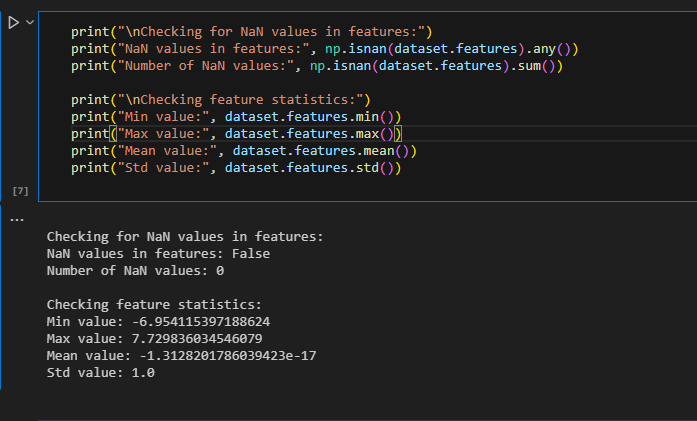

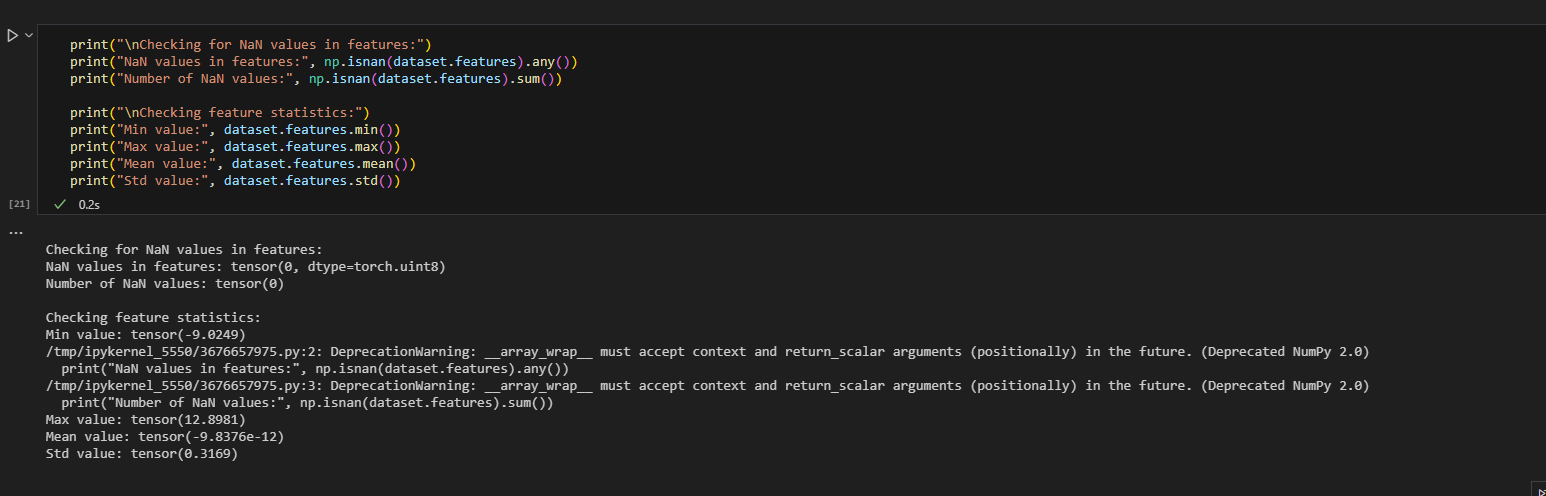

do zobaczenia tensorboard wpisz w terminal 
tensorboard --logdir runs

In [ ]:
def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:
    """
    Competition prediction function.
    Called with one sequence at a time.
    
    Args:
        sequence: Polars DataFrame with sequence data
        demographics: Polars DataFrame with demographics data
        
    Returns:
        str: Predicted gesture name
    """
    # Convert Polars DataFrame to Pandas
    sequence_pd = sequence.to_pandas()
    
    # Make prediction using our model
    predicted_gesture = predict_sequence(sequence_pd, model)
    
    # Validate if prediction is valid
    metric = CompetitionMetric()
    if predicted_gesture not in metric.all_classes:
        # If prediction is invalid, return a safe default
        return 'Text on phone'  # One of the non-target gestures
        
    return predicted_gesture

# Test the prediction function on a single sequence from validation set
test_sequence_idx = val_data.indices[0]
test_sequence = train_df[train_df['sequence_id'] == train_df['sequence_id'].unique()[test_sequence_idx]]
test_demographics = train_demo_df[train_demo_df['subject'] == test_sequence['subject'].iloc[0]]

# Convert to Polars for testing
test_sequence_pl = pl.from_pandas(test_sequence)
test_demographics_pl = pl.from_pandas(test_demographics)

print("Testing prediction function:")
print(f"True gesture: {test_sequence['gesture'].iloc[0]}")
print(f"Predicted gesture: {predict(test_sequence_pl, test_demographics_pl)}")